In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
from WindPy import w
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [4]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [5]:
wind.tail()

,Wind Index,Wind Index PE
881001.WI,,
2019-05-31,3913.6616,16.662600
2019-06-28,4045.6673,17.120399
2019-07-31,4041.1186,16.937901
2019-08-30,4011.1518,16.622400
2019-09-30,4042.0189,16.859600


In [6]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', index_col=0)

In [7]:
df.tail()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
1997-12-31 00:00:00,,,,,,,,,
2019-05-31,596.6219,47291.4060,38111.11128,2311.308,1.5,13.9884,10.6057,18.1214,2.375
2019-06-28,622.3227,50367.8950,40570.77110,2332.635,1.5,14.3395,11.1739,19.2795,2.375
2019-07-31,616.6612,49227.2291,41258.18091,2329.893,1.5,14.1668,10.8744,19.5385,2.125
2019-08-30,584.5211,47486.8247,42211.86264,2409.096,1.5,13.9843,10.0707,19.2363,2.125
2019-09-30,589.7056,48332.0886,42951.80476,2388.719,1.5,13.9797,10.1109,19.6025,1.875


In [8]:
df = df.merge(wind, left_index=True, right_index=True)

In [9]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [10]:
assets_ret = df[asset_columns].pct_change()

In [11]:
fed_rate = df['FDTRMID Index']

In [12]:
assets_ret.head()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
1999-12-31,NaN,NaN,NaN,NaN
2000-01-31,0.160787,-0.085760,-0.050449,0.002609
2000-02-29,0.122079,0.105179,-0.018823,0.015038
2000-03-31,0.055354,0.018554,0.097842,0.019860
2000-04-28,0.012971,-0.106297,-0.029946,-0.003167


# 计算估值偏离

In [13]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [14]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [15]:
pe_dev = pe_dev.dropna()

In [16]:
pe.tail()

,Wind Index PE,HSI Index PE,SPX Index PE
2019-05-31,16.662600,10.6057,18.1214
2019-06-28,17.120399,11.1739,19.2795
2019-07-31,16.937901,10.8744,19.5385
2019-08-30,16.622400,10.0707,19.2363
2019-09-30,16.859600,10.1109,19.6025


# 回测

In [17]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [18]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [19]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [20]:
assets_ret = assets_ret[assets_ret.index >= '2012-01-01']

In [21]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [22]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [23]:
portfolio.tail()

2019-05-31   -0.046866
2019-06-28    0.047257
2019-07-31   -0.002166
2019-08-30    0.001448
2019-09-30    0.009434
dtype: float64

In [24]:
metric(portfolio)

Annual return: 12.20%
Sharpe ratio: 1.01
Annual volatility: 12.05%
Max drawdown: -15.67%


# 业绩对比

In [25]:
data = w.wsd('000001.SH, CBA00101.CS, HSI.HI,SPX.GI', 'pct_chg', '2012-01-01', '2019-08-30', 'Period=M')

In [26]:
bdf = pd.DataFrame(np.array(data.Data).T/100, index=data.Times, columns=data.Codes)

In [27]:
bdf.iloc[0] = 0

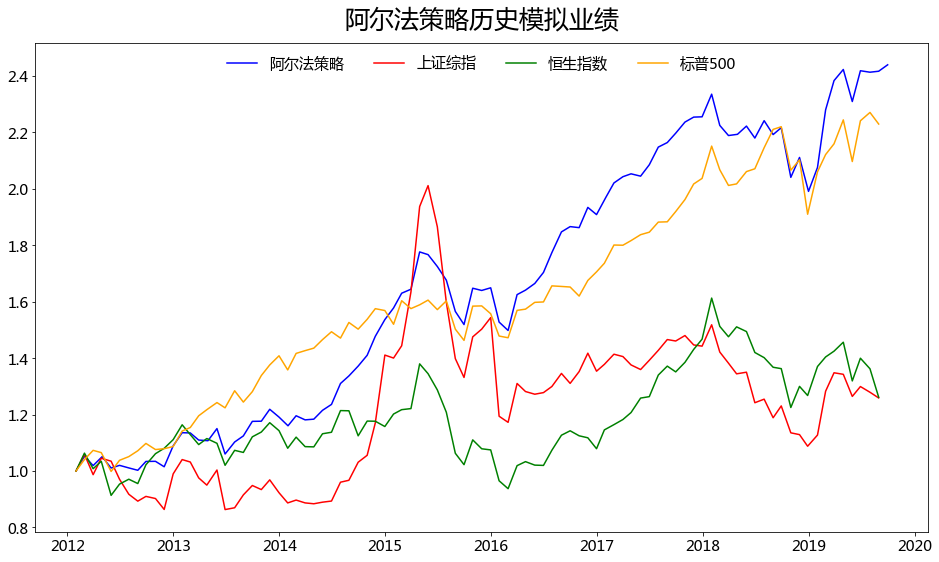

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'阿尔法策略')
lns2 = ax.plot((1 + bdf['000001.SH']).cumprod(), color='red', label=u'上证综指')
lns3 = ax.plot((1 + bdf['HSI.HI']).cumprod(), color='green', label=u'恒生指数')
lns4 = ax.plot((1 + bdf['SPX.GI']).cumprod(), color='orange', label=u'标普500')

lns = lns1 + lns2 + lns3 + lns4
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'阿尔法策略历史模拟业绩', fontsize=25, y=1.02)

In [29]:
weight = weight.astype(np.float32)

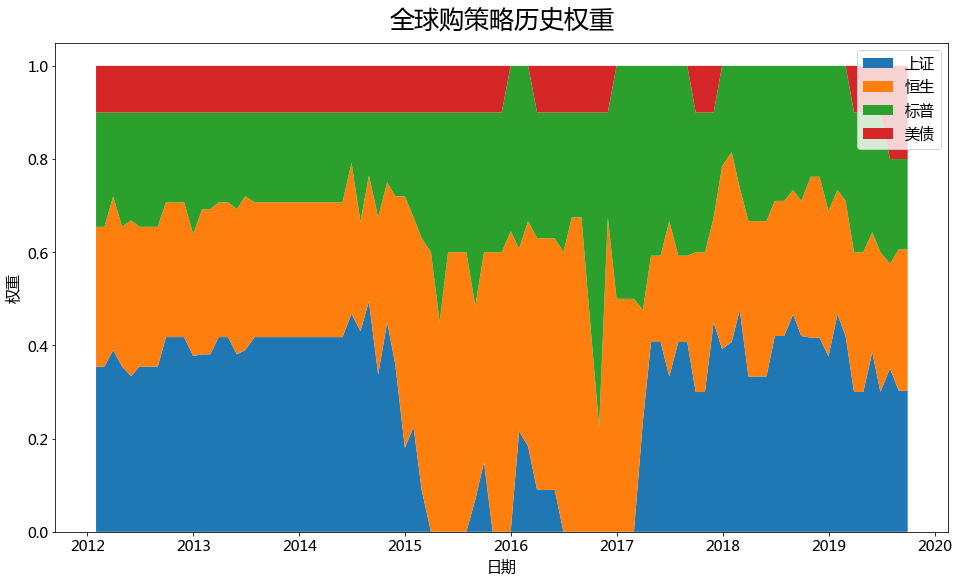

In [30]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'美债'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [31]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-05-31,0.385714,0.257143,0.257143,0.1
2019-06-28,0.300000,0.300000,0.300000,0.1
2019-07-31,0.350877,0.224561,0.224561,0.2
2019-08-30,0.303030,0.303030,0.193939,0.2
2019-09-30,0.303030,0.303030,0.193939,0.2


In [35]:
weight.to_excel('../data/weight.xlsx')